# Phân Loại Lá Cây Sử Dụng MobileNetV2

Notebook này thực hiện việc phân loại 9 loại lá cây khác nhau sử dụng mô hình MobileNetV2

Các phần chính trong notebook:
1. Import thư viện và thiết lập môi trường
2. Tải và khám phá dữ liệu
3. Chia dữ liệu và áp dụng data augmentation
4. Trích xuất đặc trưng và trực quan hóa
5. Xây dựng và huấn luyện mô hình MobileNetV2
6. Đánh giá mô hình trên tập validation và test
7. Sử dụng mô hình để dự đoán

## 1. Import các thư viện cần thiết

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tqdm import tqdm
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from PIL import Image

## 2. Thiết lập môi trường

In [ ]:
# Mount Google Drive để lưu trữ và truy cập dữ liệu
drive.mount('/content/drive', force_remount=True)

# Thiết lập device (GPU nếu có, ngược lại thì dùng CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng device: {device}")

Mounted at /content/drive
Sử dụng device: cuda


## 3. Định nghĩa các phép biến đổi dữ liệu (Data Transforms)

Các phép biến đổi này giúp chuẩn hóa và tăng cường dữ liệu, giúp mô hình học tốt hơn.

In [ ]:
# Định nghĩa transform cho từng tập dữ liệu
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize ảnh về kích thước 224x224
        transforms.RandomHorizontalFlip(p=0.5),  # Lật ngang ngẫu nhiên với xác suất 50%
        transforms.RandomRotation(15),  # Xoay ngẫu nhiên trong khoảng ±15 độ
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Thay đổi màu sắc
        transforms.ToTensor(),  # Chuyển thành tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

## 4. Tải và khám phá dữ liệu

In [ ]:
# Đường dẫn đến dữ liệu (thay đổi theo đường dẫn của bạn)
data_dir = '/content/drive/MyDrive/KHDL/dataset'
full_dataset = ImageFolder(data_dir, transform=data_transforms['val'])

# In thông tin về dataset
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes
print(f"Số lớp: {num_classes}")
print(f"Tên các lớp: {class_names}")
print(f"Tổng số ảnh: {len(full_dataset)}")

Số lớp: 9
Tên các lớp: ['apple_leaf', 'centella', 'coriander', 'greentea_leaf', 'kumquat', 'lemon', 'lemongrass', 'lime', 'papaya_leaf']
Tổng số ảnh: 3443


## 5. Phân tích phân phối dữ liệu

Hiển thị số lượng ảnh trong từng lớp để hiểu rõ phân phối dữ liệu.

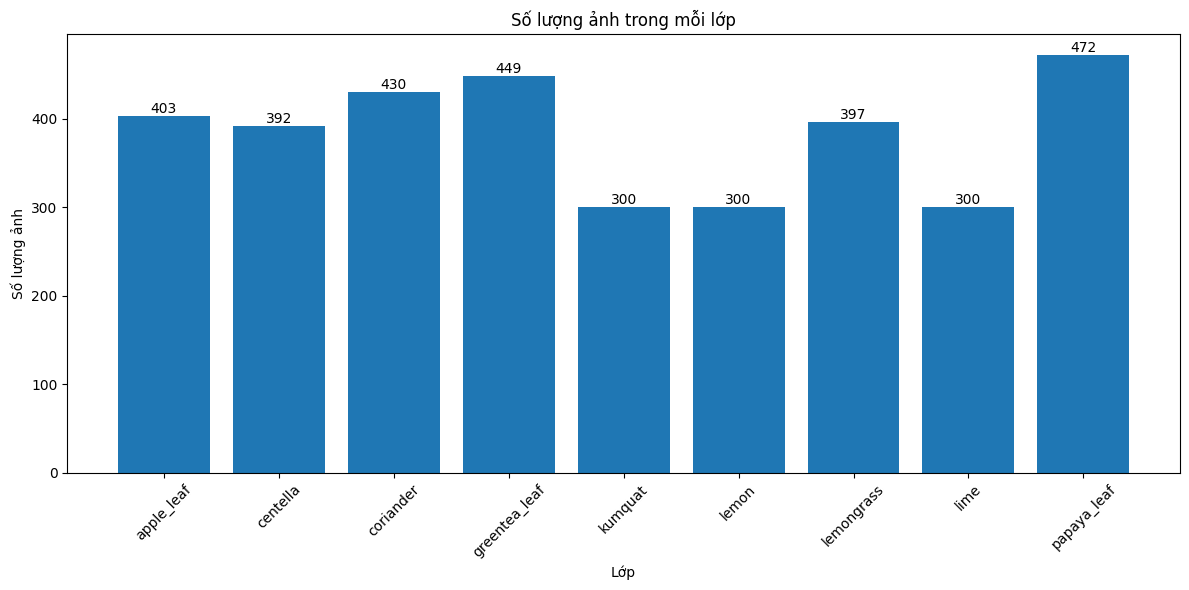

In [ ]:
# Đếm số lượng ảnh trong mỗi lớp
class_counts = [0] * num_classes
for _, label in full_dataset:
    class_counts[label] += 1

# Vẽ biểu đồ phân phối lớp
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_counts)
plt.title('Số lượng ảnh trong mỗi lớp')
plt.xlabel('Lớp')
plt.ylabel('Số lượng ảnh')
plt.xticks(rotation=45)

# Thêm số lượng lên mỗi cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height}',
            ha='center', va='bottom')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/KHDL/class_distribution.png')
plt.show()

## 6. Chia dữ liệu thành tập Train/Validation/Test

Chia dữ liệu theo tỷ lệ: 75% train, 15% validation, 10% test

In [ ]:
# Chia dataset thành train (75%), validation (15%), test (10%)
total_size = len(full_dataset)
train_size = int(0.75 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Đặt seed để kết quả có thể tái tạo lại được
torch.manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Áp dụng transform riêng cho từng tập
train_dataset.dataset.transform = data_transforms['train']  # Transform cho tập train có augmentation
val_dataset.dataset.transform = data_transforms['val']      # Transform cho tập validation
test_dataset.dataset.transform = data_transforms['test']    # Transform cho tập test

# In số lượng ảnh trong mỗi tập
print(f"Số lượng ảnh train: {len(train_dataset)}")
print(f"Số lượng ảnh validation: {len(val_dataset)}")
print(f"Số lượng ảnh test: {len(test_dataset)}")

# Tạo DataLoader để load dữ liệu trong quá trình huấn luyện
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}

Số lượng ảnh train: 2582
Số lượng ảnh validation: 516
Số lượng ảnh test: 345


## 7. Hiển thị một số hình ảnh mẫu

Hàm này giúp xem trước các hình ảnh trong dataset sau khi đã áp dụng các phép biến đổi.

Hiển thị hình ảnh mẫu từ tập train:


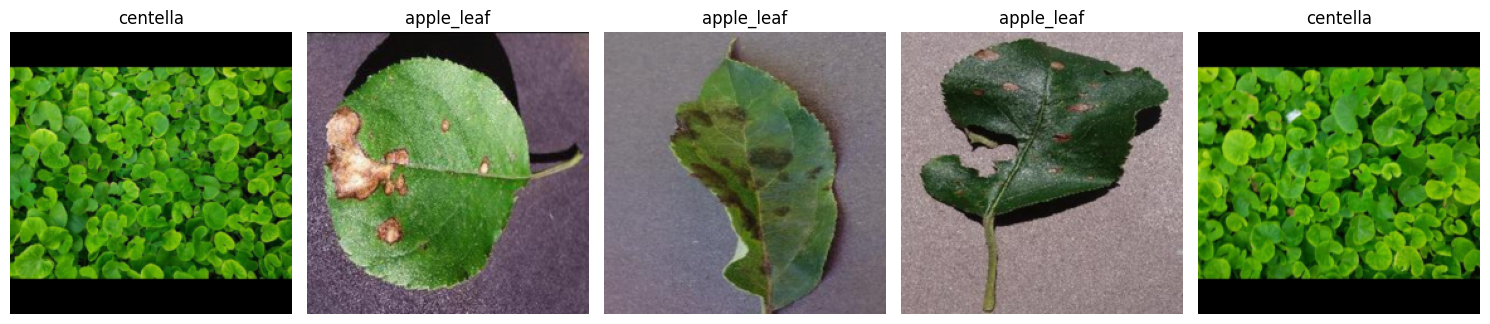

In [ ]:
# Hàm hiển thị một số hình ảnh mẫu từ dataset
def show_images_batch(dataloader):
    # Lấy một batch từ dataloader
    images, labels = next(iter(dataloader))
    # Chuyển đổi lại để hiển thị
    images = images.numpy()
    # Số ảnh hiển thị
    n_images = min(5, len(images))

    # Hiển thị các ảnh
    fig, axes = plt.subplots(1, n_images, figsize=(15, 4))
    for i in range(n_images):
        img = np.transpose(images[i], (1, 2, 0))  # Chuyển từ [C, H, W] sang [H, W, C]
        # Chuyển lại từ normalize để hiển thị đúng màu sắc
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)  # Đảm bảo giá trị nằm trong khoảng [0, 1]

        axes[i].imshow(img)
        axes[i].set_title(f"{class_names[labels[i]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/KHDL/sample_images.png')
    plt.show()

# Hiển thị 5 hình ảnh mẫu từ tập huấn luyện
print("Hiển thị hình ảnh mẫu từ tập train:")
show_images_batch(dataloaders['train'])

## 8. Trích xuất đặc trưng

Sử dụng mô hình MobileNetV2 không có pretrained để trích xuất đặc trưng từ ảnh.

In [ ]:
# Tạo một mô hình để trích xuất đặc trưng
feature_extractor = torchvision.models.mobilenet_v2(pretrained=False)  # Không sử dụng pretrained weights
# Loại bỏ lớp phân loại cuối cùng
feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1])
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, m

In [ ]:
# Hàm trích xuất đặc trưng từ tập dữ liệu
def extract_features(dataloader, model, num_samples=300):
    features = []
    labels = []
    count = 0

    with torch.no_grad():  # Không tính gradient để tiết kiệm bộ nhớ
        for inputs, targets in tqdm(dataloader, desc="Trích xuất đặc trưng"):
            inputs = inputs.to(device)
            batch_features = model(inputs)
            # Chuyển từ [batch_size, channels, 1, 1] sang [batch_size, channels]
            # Bộ trích xuất đặc trưng *nên* xuất ra [batch_size, channels, 1, 1]
            # sau khối convolutional cuối cùng trước lớp pooling, nhưng nếu không
            # chúng ta cần làm phẳng các chiều không gian (H*W)

            # Reshape features từ [batch_size, channels, H, W] thành [batch_size, channels * H * W]
            batch_features = batch_features.view(batch_features.size(0), -1) # Làm phẳng

            features.append(batch_features.cpu())
            labels.append(targets)

            count += inputs.size(0)
            if count >= num_samples:
                break

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    return features[:num_samples], labels[:num_samples]

# Trích xuất đặc trưng từ 300 ảnh đầu tiên trong tập train
print("Trích xuất đặc trưng từ hình ảnh...")
features, labels = extract_features(dataloaders['train'], feature_extractor)
print(f"Kích thước đặc trưng trích xuất: {features.shape}")

Trích xuất đặc trưng từ hình ảnh...


Trích xuất đặc trưng:  11%|█         | 9/81 [00:03<00:30,  2.34it/s]

Kích thước đặc trưng trích xuất: (300, 62720)


## 9. Giảm chiều và trực quan hóa đặc trưng

Sử dụng PCA và t-SNE để giảm chiều dữ liệu và hiển thị các đặc trưng trong không gian 2D

In [ ]:
# Giảm chiều dữ liệu bằng PCA
print("Áp dụng PCA để giảm chiều...")
pca = PCA(n_components=50)  # Giảm xuống còn 50 chiều
features_pca = pca.fit_transform(features)

print(f"Kích thước sau khi giảm chiều với PCA: {features_pca.shape}")
print(f"Tỷ lệ thông tin giữ lại sau khi giảm chiều PCA: {sum(pca.explained_variance_ratio_):.4f}")

Áp dụng PCA để giảm chiều...
Kích thước sau khi giảm chiều với PCA: (300, 50)
Tỷ lệ thông tin giữ lại sau khi giảm chiều PCA: 0.8363


Áp dụng t-SNE để trực quan hóa dữ liệu trong không gian 2D...


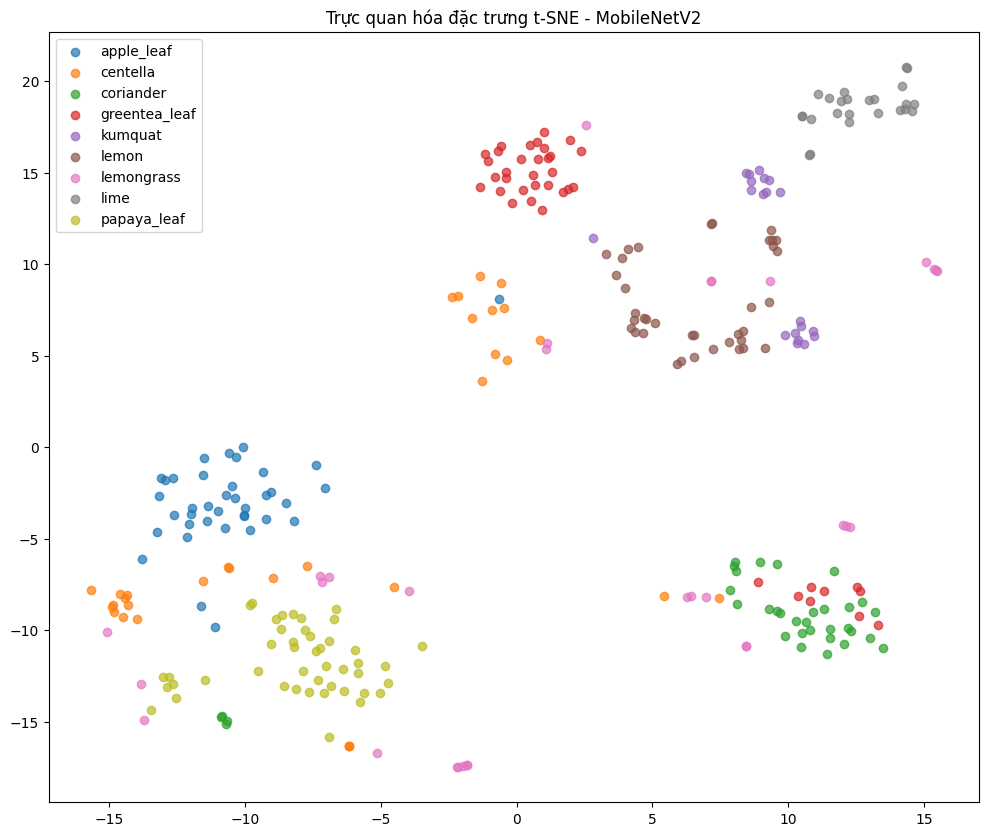

In [ ]:
# Biểu diễn đặc trưng trong không gian 2D bằng t-SNE
print("Áp dụng t-SNE để trực quan hóa dữ liệu trong không gian 2D...")
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

# Vẽ kết quả t-SNE
plt.figure(figsize=(12, 10))
for i, class_name in enumerate(class_names):
    mask = labels == i
    plt.scatter(features_tsne[mask, 0], features_tsne[mask, 1], label=class_name, alpha=0.7)

plt.title('Trực quan hóa đặc trưng t-SNE - MobileNetV2')
plt.legend()
plt.savefig('/content/drive/MyDrive/KHDL/tsne_visualization.png')
plt.show()

## 10. Tạo mô hình MobileNetV2 không sử dụng pretrained weights

Khởi tạo mô hình với pretrained=False để huấn luyện từ đầu

In [ ]:
# Tạo mô hình MobileNetV2 không dùng trọng số pretrained
def create_mobilenetv2_model():
    # Tải mô hình MobileNetV2 không có trọng số pretrained
    model = torchvision.models.mobilenet_v2(pretrained=False)

    # Thay thế lớp phân loại cuối cùng để phù hợp với số lớp của chúng ta
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),  # Thêm Dropout để giảm overfitting
        nn.Linear(in_features, num_classes)
    )

    return model

# Tạo mô hình MobileNetV2
model = create_mobilenetv2_model()
model = model.to(device)

# Hiển thị cấu trúc mô hình
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## 11. Định nghĩa hàm Loss và Optimizer

Khi huấn luyện từ đầu, ta cần tối ưu hóa toàn bộ tham số của mô hình.

In [ ]:
# Định nghĩa loss function và optimizer
criterion = nn.CrossEntropyLoss()  # Hàm loss cho bài toán phân loại

# Khác với transfer learning, ta huấn luyện toàn bộ mô hình
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 12. Định nghĩa hàm huấn luyện mô hình với Early Stopping

In [ ]:
# Hàm train mô hình với early stopping
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, patience=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_acc = 0.0
    best_val_loss = float('inf')
    best_model_wts = model.state_dict()
    early_stop_counter = 0

    # Theo dõi thời gian huấn luyện
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_batches = len(dataloaders['train'])

        train_loader = tqdm(dataloaders['train'], total=total_batches, desc="Training")
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            batch_loss = loss.item()
            batch_acc = torch.sum(preds == labels.data).double() / inputs.size(0)
            train_loader.set_postfix({'Batch Loss': f'{batch_loss:.4f}', 'Batch Acc': f'{batch_acc:.4f}'})

        epoch_train_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_train_acc = (running_corrects.double() / len(dataloaders['train'].dataset)).cpu().numpy()
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc * 100)

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        # Không tính gradient trong quá trình validation
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(dataloaders['val'].dataset)
        epoch_val_acc = (running_corrects.double() / len(dataloaders['val'].dataset)).cpu().numpy()
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc * 100)

        epoch_time = time.time() - epoch_start_time
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
        print(f'Thời gian cho epoch: {epoch_time:.2f}s')

        # Early stopping (lưu mô hình tốt nhất dựa trên validation loss)
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_acc = epoch_val_acc
            best_model_wts = model.state_dict()
            early_stop_counter = 0
            print(f"Tìm thấy mô hình tốt nhất tại epoch {epoch+1}")
        else:
            early_stop_counter += 1
            print(f"Không có cải thiện trong validation loss cho {early_stop_counter} epoch(s)")
            if early_stop_counter >= patience:
                print(f"Early stopping sau {epoch+1} epochs")
                break

    # Tổng kết quá trình huấn luyện
    total_time = time.time() - start_time
    print(f'Huấn luyện hoàn thành trong {total_time:.2f}s')
    print(f'Độ chính xác validation tốt nhất: {best_acc:.4f}')

    # Tải lại trọng số của mô hình tốt nhất
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

## 13. Định nghĩa hàm đánh giá mô hình

In [ ]:
# Hàm đánh giá mô hình trên tập test
def evaluate_model(model, dataloader, dataset_name='test'):
    model.eval()
    all_preds = []
    all_labels = []

    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Đánh giá trên tập {dataset_name}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    evaluation_time = time.time() - start_time

    # Tính toán và in các chỉ số đánh giá
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'{dataset_name.capitalize()} Accuracy: {accuracy:.4f}')
    print(f'Thời gian đánh giá: {evaluation_time:.2f}s')
    print(f'{dataset_name.capitalize()} Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))
    return all_preds, all_labels

## 14. Định nghĩa hàm vẽ ma trận nhầm lẫn

In [ ]:
# Hàm vẽ ma trận nhầm lẫn để trực quan hóa hiệu suất mô hình
def plot_confusion_matrix(all_preds, all_labels, class_names, dataset_name='validation'):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Ma Trận Nhầm Lẫn trên tập {dataset_name.capitalize()} - MobileNetV2')
    plt.xlabel('Dự Đoán')
    plt.ylabel('Thực Tế')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/KHDL/mobilenetv2_confusion_matrix_{dataset_name}.png')
    plt.show()

## 15. Huấn luyện mô hình MobileNetV2

In [ ]:
# Train mô hình MobileNetV2 không sử dụng pretrained weights
print("\nBắt đầu huấn luyện mô hình MobileNetV2 (No Pretrained)...")
num_epochs = 50
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, dataloaders, criterion, optimizer, num_epochs, patience
)


Bắt đầu huấn luyện mô hình MobileNetV2 (No Pretrained)...
Epoch 1/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.68it/s, Batch Loss=0.2363, Batch Acc=0.9091]


Train Loss: 0.7837 Acc: 0.7173
Val Loss: 0.8135 Acc: 0.7267
Thời gian cho epoch: 25.95s
Tìm thấy mô hình tốt nhất tại epoch 1
Epoch 2/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.81it/s, Batch Loss=0.8376, Batch Acc=0.7273]


Train Loss: 0.3364 Acc: 0.8850
Val Loss: 0.4739 Acc: 0.8663
Thời gian cho epoch: 26.01s
Tìm thấy mô hình tốt nhất tại epoch 2
Epoch 3/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.80it/s, Batch Loss=0.0288, Batch Acc=1.0000]


Train Loss: 0.1890 Acc: 0.9400
Val Loss: 0.5399 Acc: 0.8275
Thời gian cho epoch: 26.40s
Không có cải thiện trong validation loss cho 1 epoch(s)
Epoch 4/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.84it/s, Batch Loss=0.0255, Batch Acc=1.0000]


Train Loss: 0.1958 Acc: 0.9407
Val Loss: 0.1707 Acc: 0.9457
Thời gian cho epoch: 26.06s
Tìm thấy mô hình tốt nhất tại epoch 4
Epoch 5/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.82it/s, Batch Loss=0.2768, Batch Acc=0.9545]


Train Loss: 0.1454 Acc: 0.9574
Val Loss: 0.2191 Acc: 0.9360
Thời gian cho epoch: 25.72s
Không có cải thiện trong validation loss cho 1 epoch(s)
Epoch 6/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.74it/s, Batch Loss=0.1251, Batch Acc=0.9545]


Train Loss: 0.1754 Acc: 0.9427
Val Loss: 0.2139 Acc: 0.9535
Thời gian cho epoch: 25.51s
Không có cải thiện trong validation loss cho 2 epoch(s)
Epoch 7/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.58it/s, Batch Loss=0.1084, Batch Acc=0.9545]


Train Loss: 0.1099 Acc: 0.9640
Val Loss: 0.1431 Acc: 0.9438
Thời gian cho epoch: 26.21s
Tìm thấy mô hình tốt nhất tại epoch 7
Epoch 8/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.59it/s, Batch Loss=0.1033, Batch Acc=0.9545]


Train Loss: 0.0621 Acc: 0.9760
Val Loss: 0.1034 Acc: 0.9690
Thời gian cho epoch: 26.10s
Tìm thấy mô hình tốt nhất tại epoch 8
Epoch 9/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.61it/s, Batch Loss=0.0099, Batch Acc=1.0000]


Train Loss: 0.0751 Acc: 0.9744
Val Loss: 0.1562 Acc: 0.9516
Thời gian cho epoch: 25.97s
Không có cải thiện trong validation loss cho 1 epoch(s)
Epoch 10/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.61it/s, Batch Loss=0.1155, Batch Acc=0.9545]


Train Loss: 0.0691 Acc: 0.9760
Val Loss: 0.4286 Acc: 0.8624
Thời gian cho epoch: 26.18s
Không có cải thiện trong validation loss cho 2 epoch(s)
Epoch 11/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.62it/s, Batch Loss=0.5594, Batch Acc=0.8636]


Train Loss: 0.1155 Acc: 0.9667
Val Loss: 0.1056 Acc: 0.9709
Thời gian cho epoch: 26.03s
Không có cải thiện trong validation loss cho 3 epoch(s)
Epoch 12/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.61it/s, Batch Loss=0.1435, Batch Acc=0.9545]


Train Loss: 0.0738 Acc: 0.9756
Val Loss: 0.1593 Acc: 0.9496
Thời gian cho epoch: 25.92s
Không có cải thiện trong validation loss cho 4 epoch(s)
Epoch 13/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.70it/s, Batch Loss=0.1373, Batch Acc=0.9545]


Train Loss: 0.0760 Acc: 0.9748
Val Loss: 0.1662 Acc: 0.9554
Thời gian cho epoch: 26.04s
Không có cải thiện trong validation loss cho 5 epoch(s)
Epoch 14/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.82it/s, Batch Loss=0.0161, Batch Acc=1.0000]


Train Loss: 0.0532 Acc: 0.9841
Val Loss: 0.0954 Acc: 0.9729
Thời gian cho epoch: 26.11s
Tìm thấy mô hình tốt nhất tại epoch 14
Epoch 15/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.83it/s, Batch Loss=0.0067, Batch Acc=1.0000]


Train Loss: 0.0322 Acc: 0.9907
Val Loss: 0.0546 Acc: 0.9864
Thời gian cho epoch: 26.14s
Tìm thấy mô hình tốt nhất tại epoch 15
Epoch 16/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.82it/s, Batch Loss=0.0265, Batch Acc=1.0000]


Train Loss: 0.0461 Acc: 0.9880
Val Loss: 0.0750 Acc: 0.9826
Thời gian cho epoch: 26.19s
Không có cải thiện trong validation loss cho 1 epoch(s)
Epoch 17/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.83it/s, Batch Loss=0.0101, Batch Acc=1.0000]


Train Loss: 0.0599 Acc: 0.9768
Val Loss: 0.2342 Acc: 0.9399
Thời gian cho epoch: 25.31s
Không có cải thiện trong validation loss cho 2 epoch(s)
Epoch 18/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.66it/s, Batch Loss=0.0035, Batch Acc=1.0000]


Train Loss: 0.0561 Acc: 0.9833
Val Loss: 0.0606 Acc: 0.9845
Thời gian cho epoch: 25.69s
Không có cải thiện trong validation loss cho 3 epoch(s)
Epoch 19/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.58it/s, Batch Loss=0.0017, Batch Acc=1.0000]


Train Loss: 0.0164 Acc: 0.9954
Val Loss: 0.0603 Acc: 0.9845
Thời gian cho epoch: 26.20s
Không có cải thiện trong validation loss cho 4 epoch(s)
Epoch 20/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.59it/s, Batch Loss=0.0033, Batch Acc=1.0000]


Train Loss: 0.0166 Acc: 0.9961
Val Loss: 0.0682 Acc: 0.9903
Thời gian cho epoch: 26.10s
Không có cải thiện trong validation loss cho 5 epoch(s)
Epoch 21/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.53it/s, Batch Loss=0.0085, Batch Acc=1.0000]


Train Loss: 0.0163 Acc: 0.9946
Val Loss: 0.2941 Acc: 0.9341
Thời gian cho epoch: 26.65s
Không có cải thiện trong validation loss cho 6 epoch(s)
Epoch 22/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.55it/s, Batch Loss=0.0072, Batch Acc=1.0000]


Train Loss: 0.0294 Acc: 0.9903
Val Loss: 0.3156 Acc: 0.9205
Thời gian cho epoch: 26.49s
Không có cải thiện trong validation loss cho 7 epoch(s)
Epoch 23/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.58it/s, Batch Loss=0.0089, Batch Acc=1.0000]


Train Loss: 0.0446 Acc: 0.9861
Val Loss: 0.1641 Acc: 0.9612
Thời gian cho epoch: 26.35s
Không có cải thiện trong validation loss cho 8 epoch(s)
Epoch 24/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.61it/s, Batch Loss=0.0370, Batch Acc=1.0000]


Train Loss: 0.0534 Acc: 0.9822
Val Loss: 0.0863 Acc: 0.9767
Thời gian cho epoch: 26.15s
Không có cải thiện trong validation loss cho 9 epoch(s)
Epoch 25/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.69it/s, Batch Loss=0.0093, Batch Acc=1.0000]


Train Loss: 0.0535 Acc: 0.9818
Val Loss: 0.7288 Acc: 0.8508
Thời gian cho epoch: 25.92s
Không có cải thiện trong validation loss cho 10 epoch(s)
Epoch 26/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.80it/s, Batch Loss=0.0302, Batch Acc=1.0000]


Train Loss: 0.0677 Acc: 0.9818
Val Loss: 0.0830 Acc: 0.9826
Thời gian cho epoch: 26.14s
Không có cải thiện trong validation loss cho 11 epoch(s)
Epoch 27/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.83it/s, Batch Loss=0.0301, Batch Acc=1.0000]


Train Loss: 0.0508 Acc: 0.9830
Val Loss: 0.2028 Acc: 0.9457
Thời gian cho epoch: 26.24s
Không có cải thiện trong validation loss cho 12 epoch(s)
Epoch 28/50
----------


Training: 100%|██████████| 81/81 [00:20<00:00,  3.86it/s, Batch Loss=0.0075, Batch Acc=1.0000]


Train Loss: 0.0421 Acc: 0.9868
Val Loss: 0.0942 Acc: 0.9709
Thời gian cho epoch: 25.74s
Không có cải thiện trong validation loss cho 13 epoch(s)
Epoch 29/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.75it/s, Batch Loss=0.0502, Batch Acc=0.9545]


Train Loss: 0.0213 Acc: 0.9923
Val Loss: 0.0406 Acc: 0.9903
Thời gian cho epoch: 25.98s
Tìm thấy mô hình tốt nhất tại epoch 29
Epoch 30/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.72it/s, Batch Loss=0.0527, Batch Acc=0.9545]


Train Loss: 0.0178 Acc: 0.9946
Val Loss: 0.0422 Acc: 0.9884
Thời gian cho epoch: 25.51s
Không có cải thiện trong validation loss cho 1 epoch(s)
Epoch 31/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.65it/s, Batch Loss=0.0017, Batch Acc=1.0000]


Train Loss: 0.0255 Acc: 0.9911
Val Loss: 0.0342 Acc: 0.9884
Thời gian cho epoch: 25.73s
Tìm thấy mô hình tốt nhất tại epoch 31
Epoch 32/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.63it/s, Batch Loss=0.0051, Batch Acc=1.0000]


Train Loss: 0.0230 Acc: 0.9934
Val Loss: 0.1144 Acc: 0.9729
Thời gian cho epoch: 25.85s
Không có cải thiện trong validation loss cho 1 epoch(s)
Epoch 33/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.62it/s, Batch Loss=0.0072, Batch Acc=1.0000]


Train Loss: 0.0269 Acc: 0.9923
Val Loss: 0.1105 Acc: 0.9709
Thời gian cho epoch: 25.97s
Không có cải thiện trong validation loss cho 2 epoch(s)
Epoch 34/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.60it/s, Batch Loss=0.0006, Batch Acc=1.0000]


Train Loss: 0.0353 Acc: 0.9915
Val Loss: 0.0564 Acc: 0.9903
Thời gian cho epoch: 26.05s
Không có cải thiện trong validation loss cho 3 epoch(s)
Epoch 35/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.64it/s, Batch Loss=0.0113, Batch Acc=1.0000]


Train Loss: 0.0362 Acc: 0.9872
Val Loss: 0.0395 Acc: 0.9884
Thời gian cho epoch: 25.96s
Không có cải thiện trong validation loss cho 4 epoch(s)
Epoch 36/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.83it/s, Batch Loss=0.0029, Batch Acc=1.0000]


Train Loss: 0.0701 Acc: 0.9822
Val Loss: 0.0885 Acc: 0.9787
Thời gian cho epoch: 25.85s
Không có cải thiện trong validation loss cho 5 epoch(s)
Epoch 37/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.86it/s, Batch Loss=0.1789, Batch Acc=0.9545]


Train Loss: 0.0344 Acc: 0.9872
Val Loss: 0.0673 Acc: 0.9806
Thời gian cho epoch: 26.05s
Không có cải thiện trong validation loss cho 6 epoch(s)
Epoch 38/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.85it/s, Batch Loss=0.0066, Batch Acc=1.0000]


Train Loss: 0.0233 Acc: 0.9911
Val Loss: 0.0187 Acc: 0.9922
Thời gian cho epoch: 25.73s
Tìm thấy mô hình tốt nhất tại epoch 38
Epoch 39/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.77it/s, Batch Loss=0.0044, Batch Acc=1.0000]


Train Loss: 0.0250 Acc: 0.9919
Val Loss: 0.0710 Acc: 0.9826
Thời gian cho epoch: 25.43s
Không có cải thiện trong validation loss cho 1 epoch(s)
Epoch 40/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.67it/s, Batch Loss=0.0014, Batch Acc=1.0000]


Train Loss: 0.0076 Acc: 0.9988
Val Loss: 0.0311 Acc: 0.9942
Thời gian cho epoch: 25.71s
Không có cải thiện trong validation loss cho 2 epoch(s)
Epoch 41/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.57it/s, Batch Loss=0.0004, Batch Acc=1.0000]


Train Loss: 0.0034 Acc: 0.9996
Val Loss: 0.0227 Acc: 0.9922
Thời gian cho epoch: 26.31s
Không có cải thiện trong validation loss cho 3 epoch(s)
Epoch 42/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.62it/s, Batch Loss=0.0535, Batch Acc=0.9545]


Train Loss: 0.0221 Acc: 0.9911
Val Loss: 0.0772 Acc: 0.9806
Thời gian cho epoch: 25.86s
Không có cải thiện trong validation loss cho 4 epoch(s)
Epoch 43/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.61it/s, Batch Loss=0.0064, Batch Acc=1.0000]


Train Loss: 0.0520 Acc: 0.9845
Val Loss: 0.0451 Acc: 0.9845
Thời gian cho epoch: 26.13s
Không có cải thiện trong validation loss cho 5 epoch(s)
Epoch 44/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.63it/s, Batch Loss=0.0028, Batch Acc=1.0000]


Train Loss: 0.0351 Acc: 0.9915
Val Loss: 0.0119 Acc: 0.9942
Thời gian cho epoch: 25.94s
Tìm thấy mô hình tốt nhất tại epoch 44
Epoch 45/50
----------


Training: 100%|██████████| 81/81 [00:22<00:00,  3.64it/s, Batch Loss=0.1101, Batch Acc=0.9545]


Train Loss: 0.0319 Acc: 0.9923
Val Loss: 0.0266 Acc: 0.9903
Thời gian cho epoch: 25.84s
Không có cải thiện trong validation loss cho 1 epoch(s)
Epoch 46/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.79it/s, Batch Loss=0.0049, Batch Acc=1.0000]


Train Loss: 0.0175 Acc: 0.9946
Val Loss: 0.0488 Acc: 0.9845
Thời gian cho epoch: 25.81s
Không có cải thiện trong validation loss cho 2 epoch(s)
Epoch 47/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.82it/s, Batch Loss=0.0017, Batch Acc=1.0000]


Train Loss: 0.0025 Acc: 1.0000
Val Loss: 0.0247 Acc: 0.9942
Thời gian cho epoch: 26.24s
Không có cải thiện trong validation loss cho 3 epoch(s)
Epoch 48/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.81it/s, Batch Loss=0.0017, Batch Acc=1.0000]


Train Loss: 0.0051 Acc: 0.9981
Val Loss: 0.0543 Acc: 0.9864
Thời gian cho epoch: 26.26s
Không có cải thiện trong validation loss cho 4 epoch(s)
Epoch 49/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.78it/s, Batch Loss=0.0513, Batch Acc=1.0000]


Train Loss: 0.0174 Acc: 0.9926
Val Loss: 0.0183 Acc: 0.9922
Thời gian cho epoch: 25.97s
Không có cải thiện trong validation loss cho 5 epoch(s)
Epoch 50/50
----------


Training: 100%|██████████| 81/81 [00:21<00:00,  3.77it/s, Batch Loss=0.0011, Batch Acc=1.0000]


Train Loss: 0.0177 Acc: 0.9950
Val Loss: 0.0300 Acc: 0.9903
Thời gian cho epoch: 25.29s
Không có cải thiện trong validation loss cho 6 epoch(s)
Huấn luyện hoàn thành trong 1299.04s
Độ chính xác validation tốt nhất: 0.9942


## 16. Vẽ biểu đồ loss và accuracy trong quá trình huấn luyện

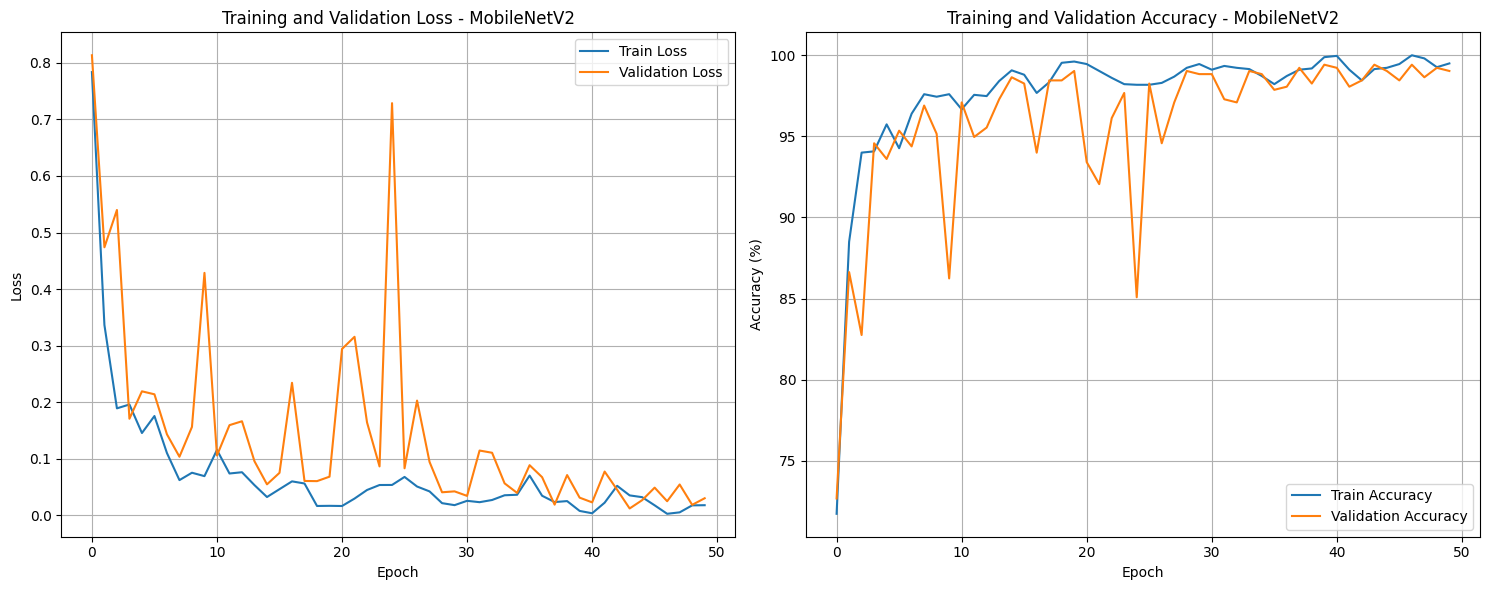

In [ ]:
# Vẽ biểu đồ loss và accuracy để theo dõi quá trình huấn luyện
plt.figure(figsize=(15, 6))

# Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss - MobileNetV2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy - MobileNetV2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/KHDL/mobilenetv2_training_plots.png')
plt.show()

## 17. Đánh giá mô hình trên tập Validation


Đánh giá trên tập Validation:


Đánh giá trên tập validation: 100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Validation Accuracy: 0.9903
Thời gian đánh giá: 7.98s
Validation Classification Report:
               precision    recall  f1-score   support

   apple_leaf       1.00      0.98      0.99        62
     centella       0.98      0.98      0.98        51
    coriander       0.98      0.98      0.98        59
greentea_leaf       1.00      0.97      0.99        75
      kumquat       1.00      1.00      1.00        43
        lemon       1.00      1.00      1.00        46
   lemongrass       0.96      1.00      0.98        68
         lime       1.00      1.00      1.00        39
  papaya_leaf       1.00      1.00      1.00        73

     accuracy                           0.99       516
    macro avg       0.99      0.99      0.99       516
 weighted avg       0.99      0.99      0.99       516



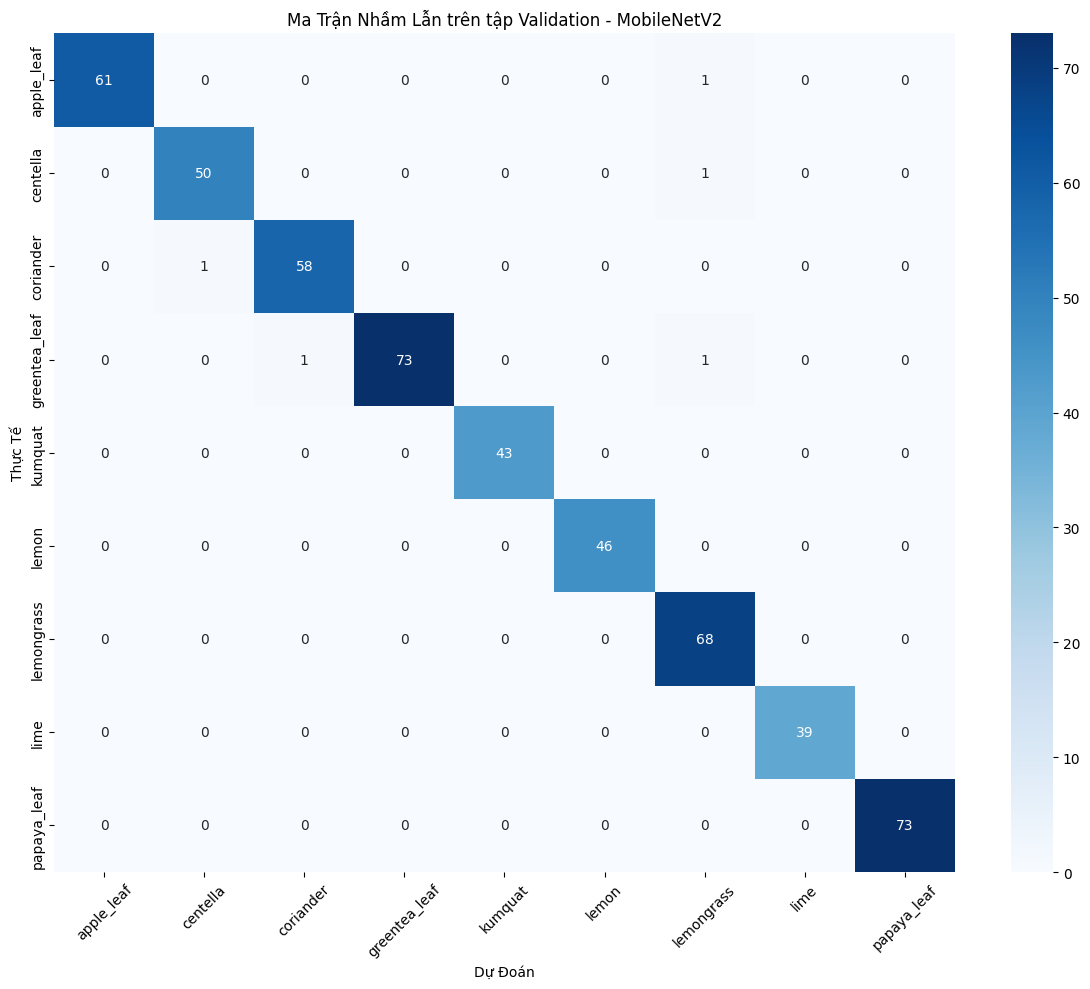

In [ ]:
# Đánh giá mô hình trên tập validation
print("\nĐánh giá trên tập Validation:")
val_preds, val_labels = evaluate_model(model, dataloaders['val'], dataset_name='validation')
plot_confusion_matrix(val_preds, val_labels, class_names, dataset_name='validation')

## 18. Đánh giá mô hình trên tập Test


Đánh giá trên tập Test:


Đánh giá trên tập test: 100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


Test Accuracy: 0.9913
Thời gian đánh giá: 3.62s
Test Classification Report:
               precision    recall  f1-score   support

   apple_leaf       0.98      1.00      0.99        43
     centella       0.97      0.94      0.95        31
    coriander       1.00      1.00      1.00        52
greentea_leaf       1.00      0.98      0.99        45
      kumquat       1.00      1.00      1.00        40
        lemon       1.00      1.00      1.00        28
   lemongrass       1.00      1.00      1.00        36
         lime       1.00      1.00      1.00        31
  papaya_leaf       0.97      1.00      0.99        39

     accuracy                           0.99       345
    macro avg       0.99      0.99      0.99       345
 weighted avg       0.99      0.99      0.99       345



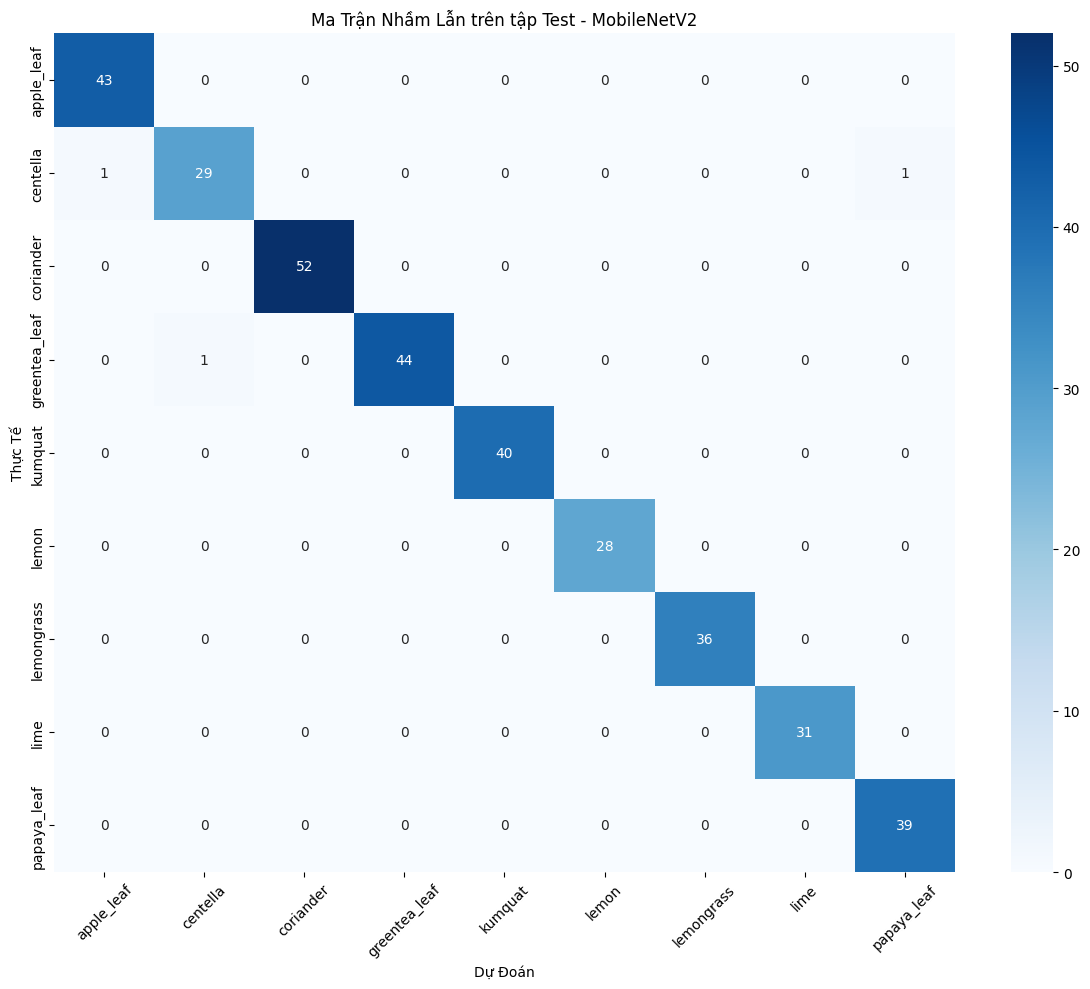

In [ ]:
# Đánh giá mô hình trên tập test
print("\nĐánh giá trên tập Test:")
test_preds, test_labels = evaluate_model(model, dataloaders['test'], dataset_name='test')
plot_confusion_matrix(test_preds, test_labels, class_names, dataset_name='test')

## 19. Lưu mô hình đã huấn luyện

In [ ]:
# Lưu mô hình đã huấn luyện
torch.save(model.state_dict(), '/content/drive/MyDrive/KHDL/mobilenetv2_nopretrained_model.pth')
print("Đã lưu mô hình tại '/content/drive/MyDrive/KHDL/mobilenetv2_nopretrained_model.pth'")

Đã lưu mô hình tại '/content/drive/MyDrive/KHDL/mobilenetv2_nopretrained_model.pth'


## 20. Tải và sử dụng lại mô hình đã lưu

In [ ]:
# Cách tải lại mô hình đã lưu để sử dụng
def load_saved_model(model_path):
    # Khởi tạo mô hình với cấu trúc giống như khi huấn luyện
    loaded_model = create_mobilenetv2_model()

    # Tải trọng số đã lưu
    loaded_model.load_state_dict(torch.load(model_path))
    loaded_model = loaded_model.to(device)
    loaded_model.eval()  # Đặt mô hình ở chế độ evaluation

    return loaded_model

# Đường dẫn đến file mô hình đã lưu
model_path = '/content/drive/MyDrive/KHDL/mobilenetv2_nopretrained_model.pth'

# Tải lại mô hình (chạy khi cần sử dụng lại mô hình đã lưu)
model = load_saved_model(model_path)
print("Đã tải mô hình thành công!")

Đã tải mô hình thành công!


## 21. Định nghĩa hàm dự đoán ảnh mới

In [ ]:
# Định nghĩa hàm dự đoán cho một ảnh mới
def predict_image(image_path, model, class_names):
    # Kiểm tra xem file ảnh có tồn tại không
    if not os.path.exists(image_path):
        print(f"Không tìm thấy ảnh tại: {image_path}")
        return None

    # Tải và xử lý ảnh
    image = Image.open(image_path).convert('RGB')
    transform = data_transforms['val']  # Sử dụng transform giống như validation
    image_tensor = transform(image).unsqueeze(0)  # Thêm batch dimension
    image_tensor = image_tensor.to(device)

    # Dự đoán
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        # Chuyển đổi output thành xác suất bằng softmax
        probabilities = torch.softmax(output, dim=1)
        _, predicted = torch.max(probabilities, 1)
        predicted_class = predicted.item()
        predicted_score = probabilities[0][predicted_class].item()  # Score của lớp dự đoán

    predicted_label = class_names[predicted_class]

    # Hiển thị ảnh và kết quả dự đoán
    plt.figure(figsize=(12, 6))

    # Hiển thị ảnh
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Dự đoán: {predicted_label} (Score: {predicted_score:.4f})")

    # Hiển thị biểu đồ xác suất cho từng lớp
    plt.subplot(1, 2, 2)
    y_pos = range(len(class_names))
    probs = [p.item() for p in probabilities[0]]

    bars = plt.bar(y_pos, probs)
    plt.xticks(y_pos, class_names, rotation=45, ha='right')
    plt.title('Xác suất các lớp')
    plt.xlabel('Lớp')
    plt.ylabel('Xác suất')

    # Đánh dấu lớp dự đoán
    bars[predicted_class].set_color('red')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/KHDL/mobilenetv2_nopretrained_prediction.png')
    plt.show()

    # In thông tin dự đoán
    print("Score cho từng lớp:")
    for i, (class_name, prob) in enumerate(zip(class_names, probabilities[0])):
        print(f"{class_name}: {prob.item():.4f}")

    print(f"Dự đoán: {predicted_label}")
    print(f"Score: {predicted_score:.4f}")

## 22. Dự đoán ảnh mẫu

Nhập đường dẫn URL tới ảnh: https://th.bing.com/th/id/OIP.6KD6PZhqh3njCKeXaeBrCwHaJ4?cb=iwc2&rs=1&pid=ImgDetMain

Dự đoán ảnh mẫu:


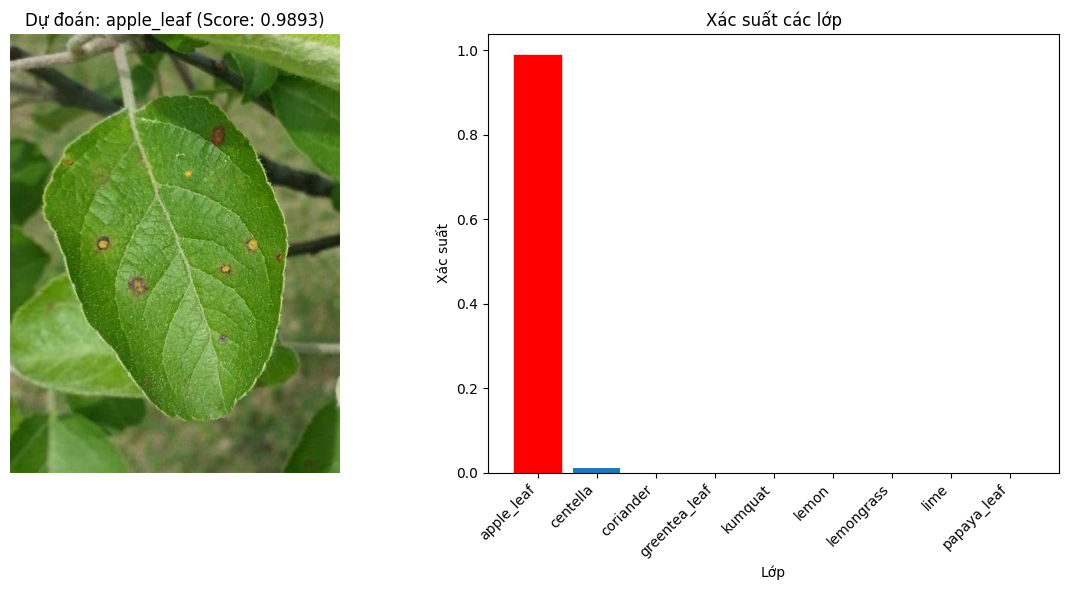

Score cho từng lớp:
apple_leaf: 0.9893
centella: 0.0107
coriander: 0.0000
greentea_leaf: 0.0000
kumquat: 0.0000
lemon: 0.0000
lemongrass: 0.0000
lime: 0.0000
papaya_leaf: 0.0000
Dự đoán: apple_leaf
Score: 0.9893


In [ ]:
import requests

def upload_and_predict_from_url(image_url, model, class_names, image_path="temp_image.jpg"):
    try:
        response = requests.get(image_url)
        response.raise_for_status()  # Gây lỗi nếu URL không hợp lệ hoặc không truy cập được

        with open(image_path, 'wb') as f:
            f.write(response.content)

        print("\nDự đoán ảnh mẫu:")
        predict_image(image_path, model, class_names)

    except Exception as e:
        print(f"Có lỗi khi tải hoặc dự đoán ảnh: {str(e)}")
        print("Vui lòng kiểm tra lại URL hoặc định dạng ảnh.")

# Ví dụ sử dụng:
image_url = input("Nhập đường dẫn URL tới ảnh: ")
upload_and_predict_from_url(image_url, model, class_names)


Saving Anthracnose(126).jpg to Anthracnose(126).jpg

Dự đoán ảnh mẫu:


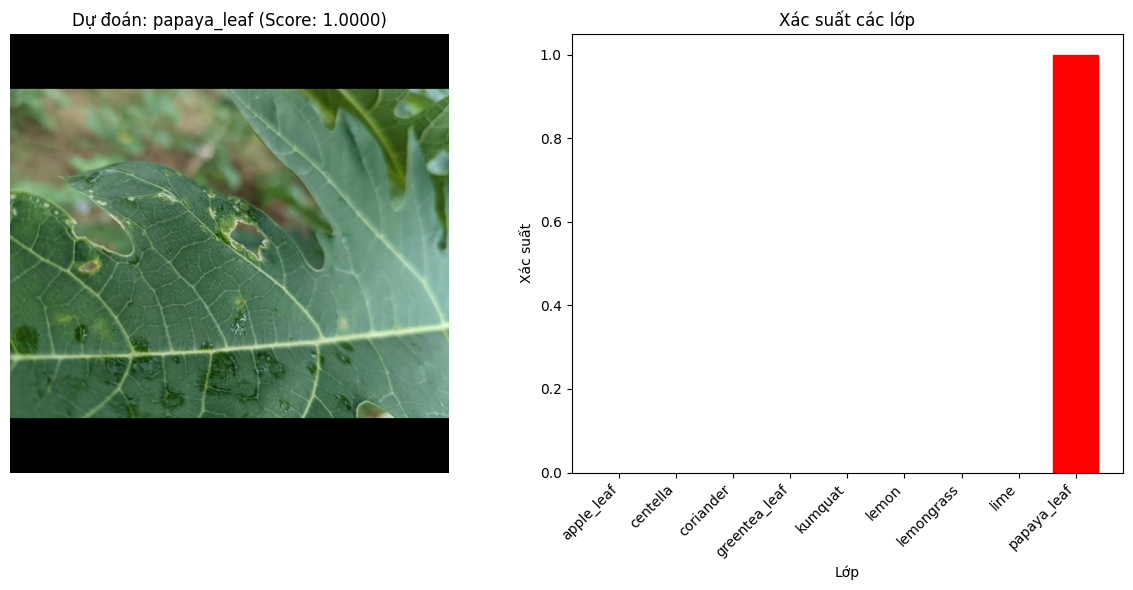

Score cho từng lớp:
apple_leaf: 0.0000
centella: 0.0000
coriander: 0.0000
greentea_leaf: 0.0000
kumquat: 0.0000
lemon: 0.0000
lemongrass: 0.0000
lime: 0.0000
papaya_leaf: 1.0000
Dự đoán: papaya_leaf
Score: 1.0000


In [ ]:
# Đường dẫn tới ảnh test
# image_path = '/content/drive/MyDrive/KHDL/real_test_image/test3.jpg'

from google.colab import files
uploaded = files.upload()
image_path = next(iter(uploaded))

# Thử dự đoán một ảnh
print("\nDự đoán ảnh mẫu:")
try:
    predict_image(image_path, model, class_names)
except Exception as e:
    print(f"Có lỗi khi dự đoán ảnh: {str(e)}")
    print("Vui lòng tải lên ảnh test hoặc cung cấp đường dẫn hợp lệ.")